In [1]:
# Blazeface inference

# derived from: https://github.com/ibaiGorordo/BlazeFace-TFLite-Inference

import tensorflow as tf
assert tf.__version__.startswith('2')

import tensorflow_datasets as tfds

import os
import math
import time
import numpy as np

import matplotlib.pyplot as plt
import PIL
from PIL import ImageDraw

print("TF version:", tf.__version__)

TF version: 2.8.0


In [2]:
# ============= #
# Configuration #
# ============= #

ROOT_DIR   = os.path.abspath('')
OUTPUT_DIR = os.path.join(ROOT_DIR, 'trained_models')

config = {
    'tfds_dataset_name': 'the300w_lp',
    'data_dir': '~/tensorflow_datasets',
    'data_train_split_percentage' : 80,
    #
    'num_test_images': 10,
}

model_type = 'custom' # 'custom_quant', 'custom', 'front', or 'back'
if model_type == 'custom_quant':
    model_spec_name =  'bf3'
    model_path = os.path.join(OUTPUT_DIR, model_spec_name)
    model_spec_name = model_spec_name + '_quant'
    config['anchor_strides'] = [8,16]
elif model_type == 'custom':
    model_spec_name =  'bf3'
    model_path = os.path.join(OUTPUT_DIR, model_spec_name)
    config['anchor_strides'] = [8,16]
elif model_type == 'front':
    model_spec_name = 'face_detection_short_range'
    model_path = OUTPUT_DIR
    config['anchor_strides'] = [8,16]
else: # 'back' # not yet working
    model_spec_name = 'face_detection_full_range'
    model_path = OUTPUT_DIR
    config['anchor_strides'] = [16,32]

config['model_file'] = os.path.join(model_path, model_spec_name + '.tflite')

In [3]:
# ====================== #
# Blaze Face Model Class #
# ====================== #

class blazeFaceDetector():
    default_config = {
        'scoreThreshold': 0.75, # 0.7
        'iouThreshold': 0.5, # 0.3
        #
        'num_anchors': [2, 6],
        'anchor_strides': [8,16],
        'num_landmarks': 6,
        'max_faces': 100,
        #
        'detect_coord_order':  'xy', # 'yx'
        'delta_normalised_or_absolute': 'absolute', # 'normalised'
        'variances': None, # [0.1, 0.1, 0.2, 0.2]
        #
        'model_file': None, # placeholder to populate from global_config
    }

    def get_config(self, global_config={}):
        config = self.default_config
        for key, value in global_config.items():
            if key in config and value:
                config[key] = value
        return config
        
    def __init__(self, global_config):
        self.config = self.get_config(global_config)

        self.config['sigmoidScoreThreshold'] = np.log(
            self.config['scoreThreshold']/(1-self.config['scoreThreshold']))
 
        self.fps = 0
        self.timeLastPrediction = time.time()
        self.frameCounter = 0

        # Initialize model
        self.initializeModel()

        # Generate anchors
        self.generateAnchors()

    class Results:
        def __init__(self, boxes, keypoints, scores):
            self.boxes = boxes
            self.keypoints = keypoints
            self.scores = scores
        
    class Anchor:
        def __init__(self, x, y, w=1, h=1):
            self.x_center = x
            self.y_center = y
            self.width = w
            self.height = h

        def to_string(self):
            anchor_s = 'x_center: {:}, y_center: {:}, w: {:}, h: {:}'.format(
                self.x_center, self.y_center, self.width, self.height)
            
            return anchor_s
    
    def generateAnchors(self):
        anchors = []
        
        for i, stride in enumerate(self.config['anchor_strides']):
            num_rows = math.floor((self.inputHeight + stride - 1) / stride)
            num_cols = math.floor((self.inputWidth  + stride - 1) / stride)
            
            num_anchors = self.config['num_anchors'][i]
            for y in range(num_rows):
                anchor_y = (stride * (y + 0.5)) / self.inputHeight
                for x in range(num_cols):
                    anchor_x = (stride * (x + 0.5)) / self.inputWidth
                    for n in range(num_anchors):
                        anchor = self.Anchor(anchor_x, anchor_y, 1., 1.)
                        anchors.append(anchor)

        self.anchors = anchors
        
    def initializeModel(self):
        print('model_file:', self.config['model_file'])
        self.interpreter = tf.lite.Interpreter(model_path=self.config['model_file'])
        self.interpreter.allocate_tensors()

        # Get model info
        self.getModelInputOutputDetails()
        
    def detectFacesRGB(self, input_image, num=0):

        # Perform inference on the input tensor
        output0, output1 = self.inference(input_image)
            
        # Figure out which output is the scores and which is the detections
        if len(output0.shape)==1 or output0.shape[-1]==1:
            # output0 is a single vector of scores, so is scores
            pred_scores = output0
            pred_deltas = output1
        else:
            # output0 is not a single vector of scores, so is detections
            pred_scores = output1
            pred_deltas = output0

        # Filter scores based on the detection scores
        scores, goodDetectionsIndices = self.filterDetections(pred_scores)
        
        # Extract information of filtered detections
        boxes, keypoints = self.extractDetections(pred_deltas, goodDetectionsIndices)

        # Filter results with non-maximum suppression
        detectionResults = self.filterWithNonMaxSupression(boxes, keypoints, scores)

        # Update fps calculator
        self.updateFps()

        return detectionResults

    def updateFps(self):
        updateRate = 1
        self.frameCounter += 1

        # Every updateRate frames calculate the fps based on the ellapsed time
        if self.frameCounter == updateRate:
            timeNow = time.time()
            ellapsedTime = timeNow - self.timeLastPrediction

            self.fps = int(updateRate/ellapsedTime)
            self.frameCounter = 0
            self.timeLastPrediction = timeNow
            
            print('ellapsedTime: {:.2f} sec'.format(ellapsedTime))

    def getGroundTruthBoxCoords(self, box):
        # ground truth boundingBox co-ord order is y1,x1,y2,x2
        y1, x1, y2, x2 = box[0], box[1], box[2], box[3]
        
        return x1, y1, x2, y2
    
    def getBoundingBoxCoords(self, box):
        # detection boundingBox co-ord order is x1,y1,x2,y2
        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
        
        return x1, y1, x2, y2
    
    def drawGroundTruthRGB(self, img, results):
        boundingBoxes = results.boxes
        keypoints = results.keypoints

        image = img.copy()
        img_width, img_height = image.size
        draw = ImageDraw.Draw(image)
        color = (18, 202, 214, 255) # RGB

        # Add bounding boxes and keypoints
        for boundingBox, keypoints in zip(boundingBoxes, keypoints):
            x1, y1, x2, y2 = self.getGroundTruthBoxCoords(boundingBox)
            x1 = (x1 * img_width).astype(int)
            x2 = (x2 * img_width).astype(int)
            y1 = (y1 * img_height).astype(int)
            y2 = (y2 * img_height).astype(int)
            box_width = x2 - x1
            box_height = y2 - y1
            if box_width <= 0 or box_height <= 0:
                continue
            draw.rectangle((x1, y1, x2, y2), outline=color, width=2)

            # Add keypoints for the current face
            for keypoint in keypoints:
                xKeypoint = (keypoint[0] * img_width).astype(int)
                yKeypoint = (keypoint[1] * img_height).astype(int)
                draw.ellipse((xKeypoint-2, yKeypoint-2,
                              xKeypoint+2, yKeypoint+2),
                             fill=color)

        return image

    def drawDetectionsRGB(self, img, results):
        boundingBoxes = results.boxes
        keypoints = results.keypoints
        scores = results.scores

        image = img.copy()
        width, height = image.size
        draw = ImageDraw.Draw(image)
        color = (255, 0, 0, 255)
        fnt = None

        # Add bounding boxes and keypoints
        for boundingBox, keypoints, score in zip(boundingBoxes, keypoints, scores):
            x1, y1, x2, y2 = self.getBoundingBoxCoords(boundingBox)
            x1 = (x1 * self.inputWidth).astype(int)
            x2 = (x2 * self.inputWidth).astype(int)
            y1 = (y1 * self.inputHeight).astype(int)
            y2 = (y2 * self.inputHeight).astype(int)
            width = x2 - x1
            height = y2 - y1
            if width <= 0 or height <= 0:
                continue
            draw.rectangle((x1, y1, x2, y2), outline=color, width=1)
            draw.text((x1, y1 - 10), '{:.2f}'.format(score),
                      font=fnt, fill=color)
            
            # Add keypoints for the current face
            for keypoint in keypoints:
                xKeypoint = (keypoint[0] * self.inputWidth).astype(int)
                yKeypoint = (keypoint[1] * self.inputHeight).astype(int)
                draw.ellipse((xKeypoint-2, yKeypoint-2,
                              xKeypoint+2, yKeypoint+2),
                             fill=color)

        return image

    def getModelInputOutputDetails(self):
        self.input_details = self.interpreter.get_input_details()
        
        input_shape = self.input_details[0]['shape']
        self.inputBatch = input_shape[0]
        self.inputHeight = input_shape[1]
        self.inputWidth = input_shape[2]
        self.inputChannels = input_shape[3]
        self.inputDataType = self.input_details[0]['dtype']

        self.output_details = self.interpreter.get_output_details()
        
    # e.g. {'scales': array([0.16255273], dtype=float32), 'zero_points': array([14], dtype=int32), 'quantized_dimension': 0}
    # https://www.tensorflow.org/lite/performance/quantization_spec
    def dequant(self, quant_tensor, quant_params):
        zero_points = quant_params.get('zero_points', 0)
        scales = quant_params.get('scales', 1)
        dequant_tensor = (quant_tensor - zero_points) * scales
        return dequant_tensor

    def inference(self, input_tensor):
        self.interpreter.set_tensor(self.input_details[0]['index'], input_tensor)
        self.interpreter.invoke()

        # get output tensors
        output0 = np.squeeze(self.interpreter.get_tensor(self.output_details[0]['index']))
        output1 = np.squeeze(self.interpreter.get_tensor(self.output_details[1]['index']))

        # dequantize if needed
        if self.inputDataType == tf.int8:
            output0 = self.dequant(output0, self.output_details[0]['quantization_parameters'])
            output1 = self.dequant(output1, self.output_details[1]['quantization_parameters'])

        return output0, output1

    def getDetectionBoxCoords(self, box, index):
        if self.config['detect_coord_order'] == 'yx':
            iy, ix, ih, iw = 0, 1, 2, 3
        else:
            ix, iy, iw, ih = 0, 1, 2, 3

        sx = box[index, ix]
        sy = box[index, iy]
        w  = box[index, iw]
        h  = box[index, ih]

        return sx, sy, w, h
    
    def getKeypointCoords(self, box_and_landmarks, index, keypoint_num):
        x = box_and_landmarks[index, 4 + (2*keypoint_num) + 0]
        y = box_and_landmarks[index, 4 + (2*keypoint_num) + 1]
        return x, y
    
    def extractDetections(self, pred_deltas, goodDetectionsIndices):

        numGoodDetections = goodDetectionsIndices.shape[0]
        
        if not self.config['variances'] is None:
            landmark_variances = self.config['num_landmarks'] * self.config['variances'][0:2]
            total_variances = self.config['variances'] + landmark_variances
            pred_deltas *= total_variances

        keypoints = np.zeros((numGoodDetections, self.config['num_landmarks'], 2))
        boxes = np.zeros((numGoodDetections, 4))
        for idx, detectionIdx in enumerate(goodDetectionsIndices):
            anchor = self.anchors[detectionIdx]
            sx, sy, w, h = self.getDetectionBoxCoords(pred_deltas, detectionIdx)

            # Original custom model used normalised delta
            # MediaPipe model uses absolute delta
            if self.config['delta_normalised_or_absolute'] == 'normalised':
                cx = (sx * anchor.width)  + anchor.x_center
                cy = (sy * anchor.height) + anchor.y_center
                w  = (w * anchor.width)
                h  = (h * anchor.height)
            else: # absolute delta, so re-normalise
                cx = (sx * anchor.width)  + anchor.x_center * self.inputWidth
                cy = (sy * anchor.height) + anchor.y_center * self.inputHeight
                w  = (w * anchor.width)
                h  = (h * anchor.height)

                cx /= self.inputWidth
                cy /= self.inputHeight
                w  /= self.inputWidth
                h  /= self.inputHeight

            for j in range(self.config['num_landmarks']):
                lx, ly = self.getKeypointCoords(pred_deltas, detectionIdx, j)
                if self.config['delta_normalised_or_absolute'] == 'normalised':
                    lx = (lx * anchor.width)  + anchor.x_center
                    ly = (ly * anchor.height) + anchor.y_center
                else: # absolute delta, so re-normalise
                    lx = (lx * anchor.width)  + anchor.x_center * self.inputWidth
                    ly = (ly * anchor.height) + anchor.y_center * self.inputHeight
                    lx /= self.inputWidth
                    ly /= self.inputHeight
                keypoints[idx,j,:] = np.array([lx, ly])
                
            boxes[idx,:] = np.array([cx - w * 0.5, cy - h * 0.5, cx + w * 0.5, cy + h * 0.5])
        return boxes, keypoints

    def filterDetections(self, pred_scores):
        # Filter based on the score threshold before applying sigmoid function
        goodDetections = np.where(pred_scores > self.config['sigmoidScoreThreshold'])[0]

        # Convert scores back from sigmoid values
        scores = 1.0 /(1.0 + np.exp(-pred_scores[goodDetections]))

        return scores, goodDetections

    def filterWithNonMaxSupression(self, boxes, keypoints, scores):
        # Filter based on non max suppression
        selected_indices = tf.image.non_max_suppression(boxes, scores, self.config['max_faces'], self.config['iouThreshold'])
        filtered_boxes = tf.gather(boxes, selected_indices).numpy()
        filtered_keypoints = tf.gather(keypoints, selected_indices).numpy()
        filtered_scores = tf.gather(scores, selected_indices).numpy()

        detectionResults = self.Results(filtered_boxes, filtered_keypoints, filtered_scores)
        return detectionResults

# Initialize face detector
faceDetector = blazeFaceDetector(config)
img_size = faceDetector.inputHeight
input_data_type = faceDetector.inputDataType

model_file: /Users/colosb01/RaspberryPI/git/tf_experiments/trained_models/bf3/bf3.tflite


In [4]:
# ============ #
# Prepare data #
# ============ #

# reduce total landmarks in data-set to just what is needed for blazeface
def filter_landmarks(landmarks):
    # Left eye
    left_eye_coords = tf.reduce_mean(landmarks[..., 36:42, :], -2)
    # Right eye
    right_eye_coords = tf.reduce_mean(landmarks[..., 42:48, :], -2)
    # Left ear
    left_ear_coords = tf.reduce_mean(landmarks[..., 0:2, :], -2)
    # Right ear
    right_ear_coords = tf.reduce_mean(landmarks[..., 15:17, :], -2)
    # Nose
    nose_coords = tf.reduce_mean(landmarks[..., 27:36, :], -2)
    # Mouth
    mouth_coords = tf.reduce_mean(landmarks[..., 48:68, :], -2)
    return tf.stack([
        left_eye_coords,
        right_eye_coords,
        left_ear_coords,
        right_ear_coords,
        nose_coords,
        mouth_coords,
    ], -2)

def generate_bboxes_from_landmarks(landmarks):
    ix, iy = 0, 1
    padding = 5e-3
    x1 = tf.reduce_min(landmarks[..., ix], -1) - padding
    x2 = tf.reduce_max(landmarks[..., ix], -1) + padding
    y1 = tf.reduce_min(landmarks[..., iy], -1) - padding
    y2 = tf.reduce_max(landmarks[..., iy], -1) + padding

    gt_boxes = tf.stack([y1, x1, y2, x2], -1)
    return tf.clip_by_value(gt_boxes, 0, 1)

def preprocessing(image_data, final_height, final_width, data_type=tf.float32):
    img = image_data["image"]
    img = tf.image.convert_image_dtype(img, tf.float32)
    gt_landmarks = tf.expand_dims(image_data["landmarks_2d"], 0)
    gt_boxes = generate_bboxes_from_landmarks(gt_landmarks)
    gt_landmarks = filter_landmarks(gt_landmarks)
    img = tf.image.resize(img, (final_height, final_width))
    img = tf.image.convert_image_dtype(img, data_type)
    if data_type == tf.float32:
        img = (img - 0.5) / 0.5
    return img, gt_boxes, gt_landmarks

# Prepare data

print('Loading tfds dataset:', config['tfds_dataset_name'])
rest_split  = 'train[{}%:]'.format(config['data_train_split_percentage'])
rest_data, info     = tfds.load(config['tfds_dataset_name'], split=rest_split,  data_dir=config['data_dir'], with_info=True)

rest_total_items = info.splits[rest_split].num_examples

val_total_items  = int(rest_total_items/2)
test_total_items = rest_total_items - val_total_items

test_data = rest_data.skip(val_total_items).take(test_total_items)

test_data = test_data.map(lambda x : preprocessing(x, img_size, img_size, input_data_type))

# (images, ground truth boxes, ground truth landmarks)
data_shapes = ([None, None, None], [None, None], [None, None, None])

# (images, ground truth boxes, ground truth landmarks)
padding_values = (tf.constant(0, input_data_type), tf.constant(0, tf.float32), tf.constant(0, tf.float32))

test_data = test_data.padded_batch(1, padded_shapes=data_shapes, padding_values=padding_values)

Loading tfds dataset: the300w_lp


2022-02-16 17:42:14.366025: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ellapsedTime: 2.90 sec


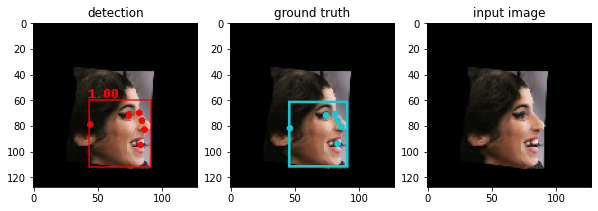

ellapsedTime: 0.37 sec


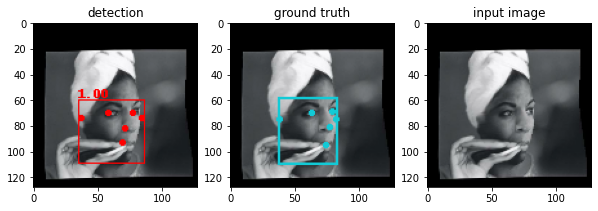

ellapsedTime: 0.30 sec


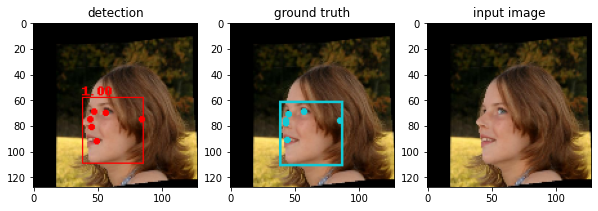

ellapsedTime: 0.31 sec


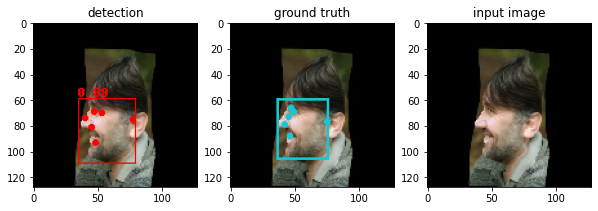

ellapsedTime: 0.44 sec


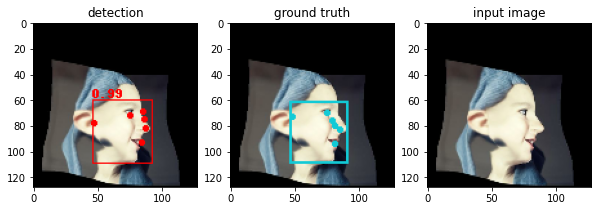

ellapsedTime: 0.29 sec


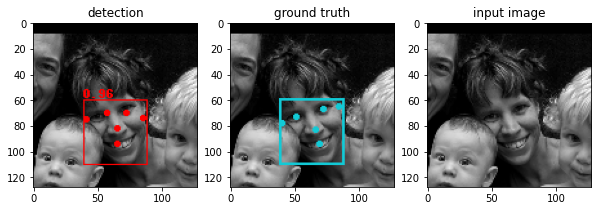

ellapsedTime: 0.32 sec


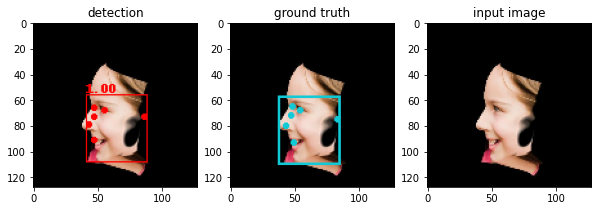

ellapsedTime: 0.29 sec


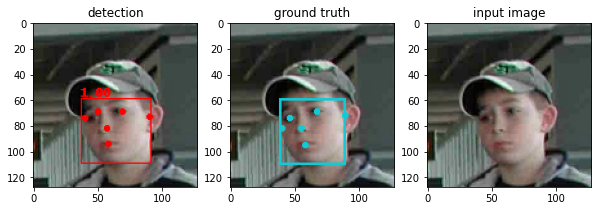

ellapsedTime: 0.31 sec


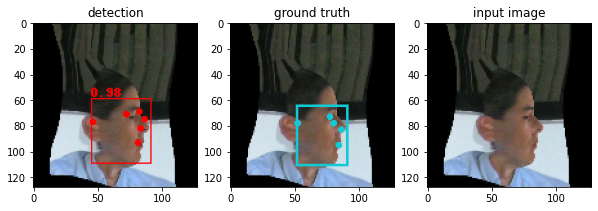

ellapsedTime: 0.30 sec


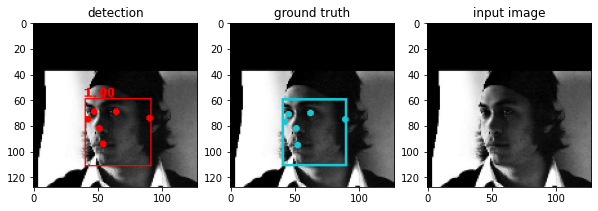

In [5]:
# =============== #
# Inference tests #
# =============== #

def singleImageTensorToPil(single_img_tensor):
    single_img_tensor = tf.image.convert_image_dtype(single_img_tensor, tf.float32)
    img_pil = tf.keras.preprocessing.image.array_to_img(single_img_tensor)
    return img_pil

for num, image_data in enumerate(test_data.take(config['num_test_images'])):

    # Get test image
    input_image, shapes, values = image_data

    groundTruthResults = faceDetector.Results(boxes=shapes[0].numpy(), keypoints=values[0].numpy(), scores=None)
        
    # Detect faces
    detectionResults = faceDetector.detectFacesRGB(input_image, num=num)

    # Draw detections and ground truth
    img_input_pil  = singleImageTensorToPil(input_image[0])
    img_detect_pil = faceDetector.drawDetectionsRGB(img_input_pil, detectionResults)
    img_truth_pil  = faceDetector.drawGroundTruthRGB(img_input_pil, groundTruthResults)
    
    width=10
    height=10
    fig, axarr = plt.subplots(1, 3, figsize=(width,height))

    axarr[0].set_title('detection')
    axarr[0].imshow(img_detect_pil)

    axarr[1].set_title('ground truth')
    axarr[1].imshow(img_truth_pil)
    
    axarr[2].set_title('input image')
    axarr[2].imshow(img_input_pil)
    
    plt.show()